In [1]:
import matplotlib.pyplot as plt
from matplotlib import collections  as mc
from IPython.display import Image
import seaborn as sns
import scipy.stats as stats 
import pandas as pd
import numpy as np
from operator import itemgetter
import statsmodels
import statsmodels.api as sm


In [2]:
import matplotlib
matplotlib.use('nbagg') # enables interactive figures, where we can zoom and move

In [3]:
# a couple more configuration of the plotting engine
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 10, 10
plt.rc("font", size=18)


plt.rc('xtick', color='k', labelsize='medium', direction='in')
plt.rc('xtick.major', size=8, pad=12)
plt.rc('xtick.minor', size=8, pad=12)

plt.rc('ytick', color='k', labelsize='medium', direction='in')
plt.rc('ytick.major', size=8, pad=12)
plt.rc('ytick.minor', size=8, pad=12)

Before  we can delve into the large topic of **Generalized Linear Models**, we are going to introduce the more general framework of **Maximum Likelihood** upon which rely most of the fitting problems of GLMs.


# 2. Maximum Likelihood

Maximum Likelihood is a method that is used to estimate parameters of a probablililty distribution. It is done by **maximizing the likelihood function**. In the case that we are interested in (i.e. independant identically distributed) this likelihood function is simply the product of  a density function values over the entire sample. **It is a parametric method** since it needs to have an a priori about the density function for it to work. 

Since it is a product, most of the time we would rather work with the log likelihood function which transforms this product into a sum.

So we would like to maximize $l$, the loglikelihood function, by choosing a set of parameters $\pmb\Theta$.
Where $l$ is of the form:

$$l(\pmb\Theta;X)=\sum_i ln(p(x_i|\pmb\Theta))$$

Where $X$ is a random variable and $p()$ is the density function associated to $X$. So you want to find the following estimation for $\pmb\Theta$

$$\hat{\pmb\Theta}=\text{arg max}_{\pmb\Theta}l(\pmb\Theta;X)$$

> Note : this formulation of the likelihood relies on the Bayes theorem. It puts forward that the likelihood of parameters given the observed data depends on the probability of the observed data given the parameters. Thus, in ML we search the parameters for which the observed data seems the most probable.


Let's take the example of a gaussian where you would like to estimate the $\sigma$ and the $\mu$, given your data. As they are simulated data we chose that $\mu=2$ and $\sigma=0.5$

In [4]:
def gaussian_dist(x,mu,sigma):
    """ returns the probability of observing x in a normal distribution of mean mu and standard deviation sigma """
    return 1./(sigma*np.sqrt(2*np.pi))*np.exp(-1./(2*sigma**2)*(x-mu)**2)

<IPython.core.display.Javascript object>


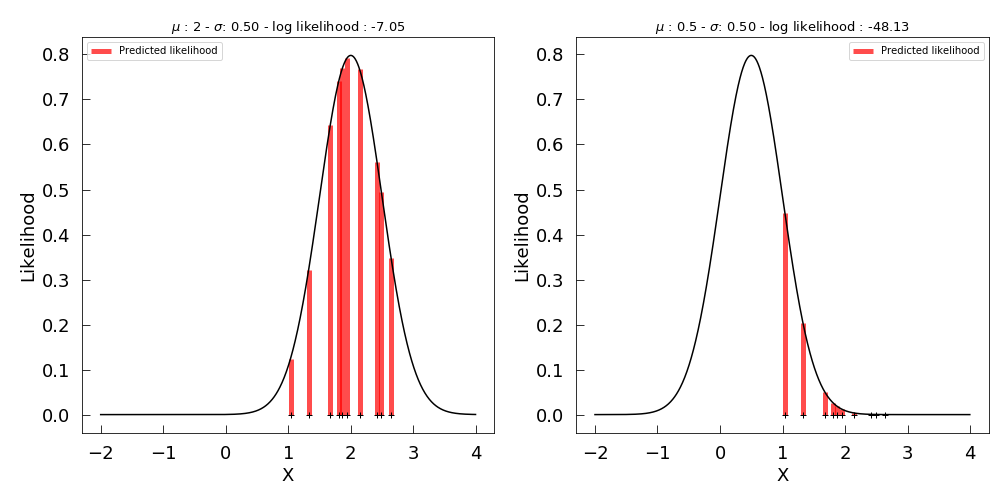

In [5]:
X_small=np.random.randn(10)*0.5+2 # this is our observed data, with ( mean=2 , sd=0.5 )

m=[2,0.5] # we will try 2 possible combinations of paramters ( mean=2 , sd=0.5 ) and ( mean=0.5 , sd=0.5 ) 
s=[0.5,0.5]


fig, ax = plt.subplots(ncols=len(m) , figsize = (14,7))
X_small_=[[v,0] for v in X_small]

x=np.arange(-2,4,0.005) # we will plot between -2 and 4

for q in range(len(m)): # for each of the parameter combinations we want to try
    ax[q].plot(X_small,[0]*len(X_small),'k+') # we plot the observed data as crosses

    ax[q].plot( x , stats.norm.pdf( x , loc = m[q] , scale = s[q] ),'k') # we plot the distribution we are testing
    
    Predicted = stats.norm.pdf( X_small , loc = m[q] , scale = s[q] )

    Predicted_= [i for i in zip(X_small,Predicted)] # this is to plot segments
    lc = mc.LineCollection(zip(X_small_,Predicted_) , colors='red',linewidths=5,alpha=0.7,label='Predicted likelihood')
    ax[q].add_collection(lc)
    ax[q].legend(loc='best',fontsize=10)
    
    # the log likelihood of this set of parameters is the sum of the log of the probability densities of the sample
    sum_like=sum(np.log(Predicted))     
    ax[q].set_title('$\mu$ : {} - $\sigma$: {:.2f} - log likelihood : {:.2f}'.format(m[q],s[q],sum_like) ,fontsize=13)
    
    ax[q].set_xlabel('X')
    ax[q].set_ylabel('Likelihood')


plt.tight_layout()    

Multiplying those red bars is exactly what the maximum likelihood does. 

Basically, you shift your theoritical distribution to the right or the left (trying different means), and you narrow it or widen it (trying different variances). 

For each of those try you multiply those red bars together, and the combination of parameters giving highest result is the one maximizing the likelihood of your data being produced by that distribution with those parameters.


It is important to point out here that **even when our data are actually coming from a certain distribution, there will (almost) always be a difference between the theoretical distribution and the recovered one**, as to have perfect match you would need an infinite number of data points.


<IPython.core.display.Javascript object>


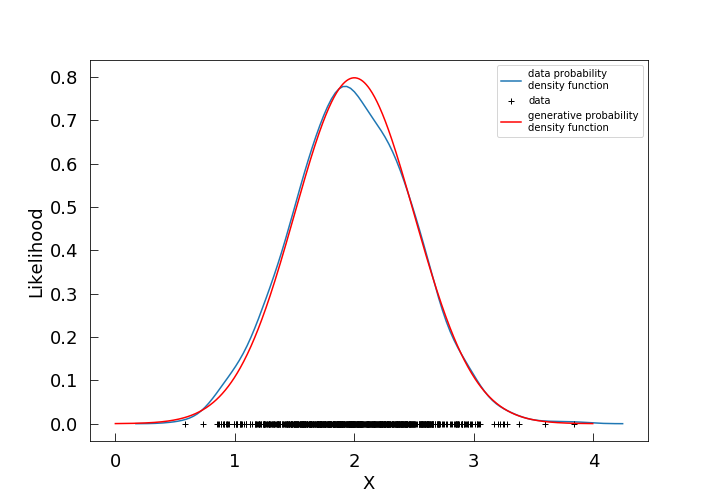

In [6]:
X=np.random.randn(800)*0.5+2
fig = plt.figure(figsize = (10,7)) 
sns.kdeplot(X,label='data probability\ndensity function')
x=np.arange(0,4,0.005)
plt.plot(X,[0]*len(X) ,'k+',label='data')
plt.plot(x, stats.norm.pdf( x , loc = 2 , scale = 0.5 ) ,'r',label='generative probability\ndensity function')
plt.ylabel('Likelihood')
plt.xlabel('X')
plt.legend(loc='best',fontsize=10)

Let's test many combinations of possible means and standard deviations to see where our maximum of likelihood lies.

Highest likelihood is for \mu and \sigma : 2.0 0.5


<IPython.core.display.Javascript object>


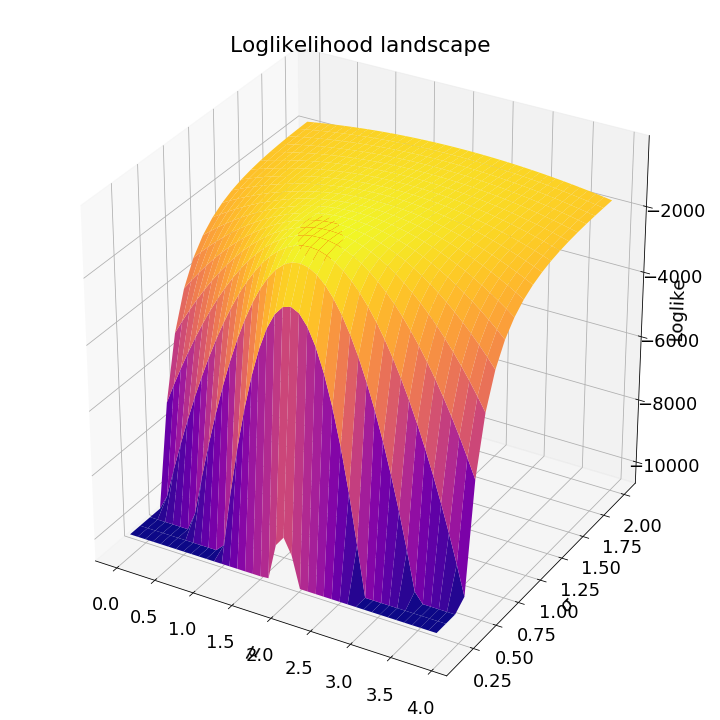

In [7]:
import math

mu=np.arange(0,4,0.1) # from 0 to 4 by increments of 0.1
sigma=np.arange(0.1,2.1,0.1) # from 0.1 to 2.1 by increments of 0.1

mu,sigma=np.meshgrid(mu,sigma) # this useful function combines all possibles values for mu and sigma
def loglike_func(X,mu,sigma):
    """returns a list of the loglikelihoods of mus and sigmas given data X"""
    ll = []
    for i in range(len(mu)):
        ll.append( sum(np.log(stats.norm.pdf(X,mu[i],sigma[i]))) )
        if math.isnan(ll[-1]) or ll[-1] < -10000: 
            ll[-1] = -10000 # we verify that no numerical error gave us an NaN or very small log value
    return ll

# we compute the log-likelihood for all tested parameters values 
zs=np.array(
    loglike_func(X,np.ravel(mu),np.ravel(sigma))
) 
loglike=zs.reshape(mu.shape)

bestMu = np.ravel(mu)[np.argmax(zs)]
bestSigma = np.ravel(sigma)[np.argmax(zs)]

# make a 3D figure of our loglikelihood landscape
from mpl_toolkits.mplot3d import Axes3D 
print(r'Highest likelihood is for \mu and \sigma :',bestMu,bestSigma)

fig = plt.figure() 
ax = Axes3D(fig)
ax.plot_surface(mu,sigma,loglike,cmap='plasma') 
ax.scatter(bestMu,bestSigma,max(zs),s=2000,c='r') # put a dot at the ML value
ax.set_xlabel('$\mu$')
ax.set_ylabel('$\sigma$')
ax.set_zlabel('Loglike')
plt.title("Loglikelihood landscape")

plt.show()

Nicely enought this maximum likelihood method allows us to recover the true parameters of the distribution.


Let us look at the curvature of the loglikelihood space as it is bearing useful information. For that we are going to look at how the log likelihood function behave in function of $\mu$ when $\sigma=0.5$. Same for the behaviour of the likelihood function according to $\sigma$ when $\mu=2$

In [8]:
def loglike_func_1Param(X,mu=2,sigma=0.5):
    ll=sum(np.log(stats.norm.pdf(X,mu,sigma)))    
    if math.isnan(ll)==True or ll<-10000:
        ll=-10000
    return ll


<IPython.core.display.Javascript object>


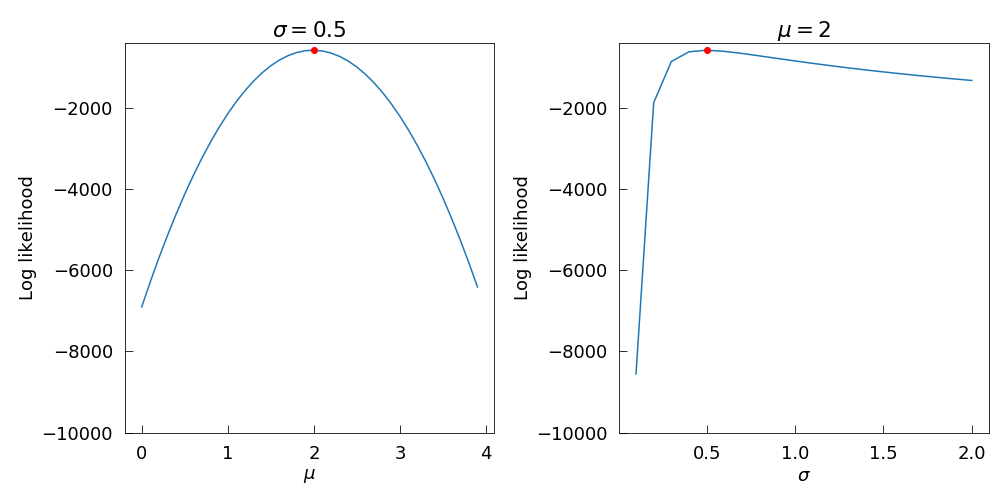

In [9]:
fig, ax = plt.subplots(ncols=len(m) , figsize = (14,7))
mu=np.arange(0,4,0.1)
sigma=np.arange(0.1,2.1,0.1)

for q in range(2): 
    if q==0: # different values of mu for sigma=0.5
        ax[q].plot(mu,[loglike_func_1Param(X,mu=v,sigma=0.5) for v in mu])
        ax[q].plot([2],[loglike_func_1Param(X,mu=2,sigma=0.5)],'ro')
        ax[q].set_xlabel('$\mu$')
        ax[q].set_ylabel('Log likelihood')
        ax[q].set_title('$\sigma=0.5$')
    if q==1: # different values of sigma for mu=2
        ax[q].plot(sigma,[loglike_func_1Param(X,sigma=v,mu=2) for v in sigma])
        ax[q].plot([0.5],[loglike_func_1Param(X,sigma=0.5,mu=2)],'ro')
        ax[q].set_xlabel('$\sigma$')
        ax[q].set_ylabel('Log likelihood')
        ax[q].set_title('$\mu=2$')
    ax[q].set_ylim([-10000,-400])
plt.tight_layout()

I would to draw a little bit of attention on the curvature of the loglikelihood function here. You can see here that the way the loglikelihood drops around the red dot is quite different for $\mu$ and $\sigma$. For $\mu$ the steepness of the slopes around the maximum are important an well defined, whereas for $\sigma$ it is way flatter. This has a direct consequence on how narrow your confidence interval around the estimated parameters are going to be. 

You can see that as the log likelihood function is flatter, there is a wider range of $\sigma$ that have a loglikelihood equivalent to the maximum.

I was talking about the "steepness of the slopes" before. In mathematical terms this corresponds to the second derivative of the loglikelihood function. The bigger this second derivative is the steeper are the slopes. You can put all those second derivatives in a matrix called the hessian matrix. In our case : 
$$
\begin{bmatrix}
    \frac{\partial^2l}{\partial\mu^2} & \frac{\partial^2l}{\partial\mu\partial\sigma} \\
    \frac{\partial^2l}{\partial\sigma\partial\mu} & \frac{\partial^2l}{\partial\sigma^2}
  \end{bmatrix}
$$

You can have a geometrical intepretation of the confidence interval by seeing that it is related to the inverse of this second derivative or the inverse of that hessian matrix. This inverse is called radius of curvature, and the bigger the second derivative is going to be, the smaller that radius of curvature is going to be. 

In other words, when the highest value really pops up from the ones around it in the likelihood landscape, then the confidence interval around the best values of the parameters is small.

### What is the link between OLS method and Maximum likelihood? What is the distribution we are trying to fit int the case of a regression?

Let's now imagine that we try to fit the average of a Y, $\hat{Y}$, along the curve $\hat{Y}=\beta X+c$ for which the noise around those averages is gaussian. 

Since we didn't put the noise in this equality, it really represents a fit of the average of Y with some gaussian noise around it. The equation representing the fitting of Y would be $Y=\beta X+c+\epsilon$. 

We could thus consider that we can switch to the following problem of distribution fitting, defined by the density function of a normal law:

$$p(y_i|\bar{y_i},\sigma)=\frac{1}{\sqrt{2\pi\sigma^2}}*\exp(-\frac{1}{2}\frac{(y_i-\bar{y_i})^2}{\sigma^2})$$

Note that the parameters you want to estimate are $\bar{y_i}$ and $\sigma$ (note that $\bar{y_i}$ serves as the mean of the normal distribution here).

By definition of the  likelihood function over $n$ individuals in a sample is:

$$\Pi_i \frac{1}{\sqrt{2\pi\sigma^2}}*\exp(-\frac{1}{2}\frac{(y_i-\bar{y_i})^2}{\sigma^2})$$

which transformed into the loglikelihood function:

$$l(\bar{y_i},\sigma;Y) = \sum_i -\frac{1}{2}\frac{(y_i-\bar{y_i})^2}{\sigma^2} + constant = -\frac{1}{2 \sigma^2} \sum_i (y_i-\bar{y_i})^2 + constant$$

And we try to find the maximum of this expression.

Now, in the frame of a linear model, we have $$\bar{y_i}=\beta x_i+c$$

And in least square, we try to find the minimum of :
$$\sum_i (y_i- \beta x_i+c )^2 = \sum_i (y_i-\bar{y_i})^2 $$




You see now that maximizing $\sum_i -(y_i-\bar{y_i})^2$ over $\beta$ (ML) is the same as minimizing $\sum_i (y_i-\bar{y_i})^2$ over $\beta$ (OLS).






#### if you want to dig deeper : What about the confidence interval ? 

As a side note for now, but important for the rest:

$$\hat{\pmb\beta}=(\pmb X^T \pmb X)^{-1}\pmb X^T \pmb Y$$

is the solution from both the maximum likelihood in the case of normally distributed noise, and the least square fit.

As a quick proof, and also to get a feeling of how all of this is working we can take the simple case of $\bar{y_i}=\beta x_i=f(x_i,\beta)$.

In that case the loglikelihood look like 

$$l=\sum_i -\frac{1}{2}\frac{(y_i-\beta x_i)^2}{\sigma^2} + constant $$

$$\frac{\partial l}{\partial \beta}\propto\sum_i -2x_iy_i + 2\beta x_i^2$$

You want $\frac{\partial l}{\partial \beta}(\hat{\beta})=0$ as you are maximizing the likelihood so you end up with:

$$\hat{\beta} \sum_i x_i^2=\sum_i x_iy_i$$

Which in multivariate actually corresponds to $(\pmb X^T \pmb X)\hat{\pmb\beta}=\pmb X^T \pmb Y$

The term $(\pmb X^T \pmb X)$ plays a special role, here and in the confidence interval seen before $\beta_j \in [\hat{\beta_j} \pm z_{1-\frac{\alpha}{2}}\sqrt{\hat{\sigma}^2 [(\pmb X^T \pmb X)^{-1}]_{j,j}}]$: 

$(\pmb X^T \pmb X)$ is generally related to the covariance of $\pmb X$. But in that specific case (normality), it is also a matrix representing the curvature of the log likelihood function at $\hat{\pmb \beta}$. You calculate the curvature of a function by calculating the matrix of second derivative called hessian. In our case you just differentiate one more time what we found before :

$$\frac{\partial^2 l}{\partial \beta^2}\propto\sum x_i^2$$

And indeed you find this $\sum x_i^2$ term which in multivariate forms is $(\pmb X^T \pmb X)$.



Calculating a confidence interval in the general case (in the case of the GLM that we will see later for example), involves inverting the curvature of the loglikelihood function at the estimated $\hat{\pmb \beta}$ and put in a normal confidence interval as seen before. 
In statistic this curvature matrix (also called hessian in mathematic) is related to the Fisher Information, which we will use later.

# 3. Generalized linear model

So, previously we saw that under some hypothesis we could use the Oridnary Least Square method to fit a curve. We also saw that if we knew that the errors were normally distributed then this OLS method was equivalent to using another method called Maximum Likelihood. We also mentioned that if the OLS hypothesis were not verified, then we could use what is called a Generalized Linear Model. As you will see this GLM also rely on the Maximum Likelihood method.

First, let's see a typical cases where our OLS is not going to work, and where I am pretty sure you will have some ideas about the underlying model we choose use instead.

#### Practical case 1 : exponential growth of Corona virus infection

In this dataset we follow the spread of covid cases over time. We would like for example to understand what is the growth rate of cases.

In [10]:
df_corona_exp=pd.read_csv('exponential_covid.csv')
df_corona_exp["Days"]=df_corona_exp.index
df_corona_exp.drop("Time",1,inplace=True)
df_corona_exp.head()

,Infections,Days
0,1,0
1,1,1
2,2,2
3,2,3
4,5,4


<IPython.core.display.Javascript object>


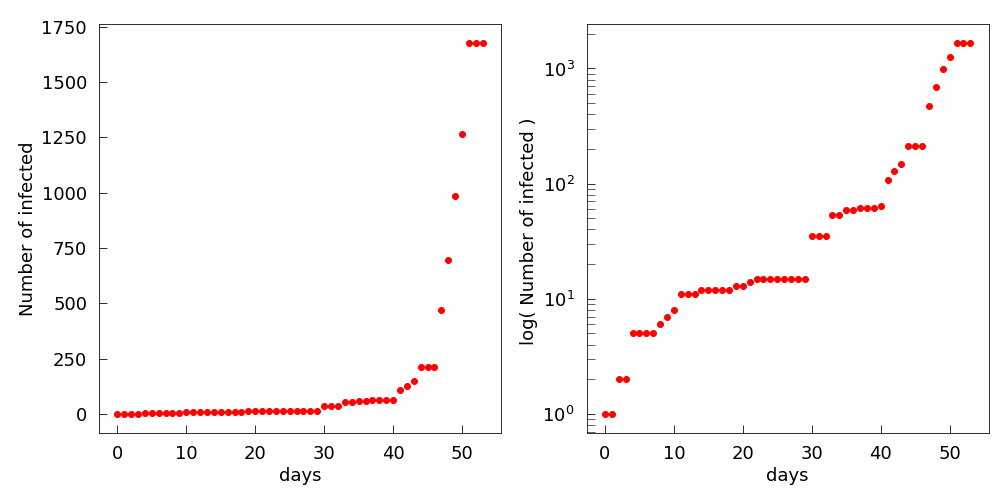

In [11]:
fig, ax = plt.subplots(ncols=2,figsize=(14,7))
ax[0].plot(list(df_corona_exp["Days"]),list(df_corona_exp["Infections"]),'ro')
ax[0].set_xlabel('days')
ax[0].set_ylabel('Number of infected')

ax[1].plot(list(df_corona_exp["Days"]),list(df_corona_exp["Infections"]),'ro')
ax[1].set_xlabel('days')
ax[1].set_ylabel('log( Number of infected ) ')
ax[1].set_yscale('log')
plt.tight_layout()

So here looking at the data, and with a little bit of domain knowledge we are looking at model of the kind $$n(t)=n(0)e^{\beta t}$$ where $\beta$ is the growth rate.  

With this kind of function it seems impossible to to be able to write $\bar{n(t)}=\pmb t^T\pmb\beta$, as we would in a ordinary linear model. 

Moreover, here $n(t)$ could follow the definition a Poisson statistic (a number of independent events during an interval t), and Poisson random variable have their mean and variance equal : so homoscedasticity is not true. 

To show this, in the next pair of plots I used a sliding window centered around each point with a stride of 5, in to calculate the mean and the variance at each point.

<IPython.core.display.Javascript object>


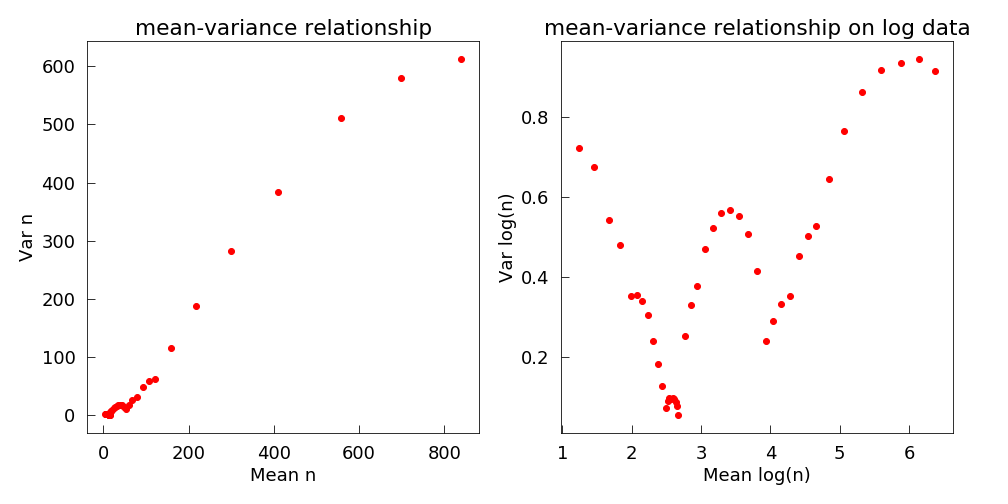

In [12]:
interv=5 #number of points to the right and to the left we look at to deduce the local mean and variance
n=list(df_corona_exp["Infections"])

fig, ax = plt.subplots(ncols=2,figsize=(14,7))

ax[0].plot([np.mean(n[v-interv:v+interv+1]) for v in range(interv,len(n)-interv,1)],
           [np.std(n[v-interv:v+interv+1]) for v in range(interv,len(n)-interv,1)],'ro')
ax[0].set_xlabel('Mean n')
ax[0].set_ylabel('Var n')
ax[0].set_title('mean-variance relationship')


ax[1].plot([np.mean(np.log(n[v-interv:v+interv+1])) for v in range(interv,len(n)-interv,1)],
           [np.std(np.log(n[v-interv:v+interv+1])) for v in range(interv,len(n)-interv,1)],'ro')
ax[1].set_xlabel('Mean log(n)')
ax[1].set_ylabel('Var log(n)')
ax[1].set_title('mean-variance relationship on log data')

plt.tight_layout()

Clearly, there is a relationship between the mean and the variance in the number of infected person.

Consequently, this does not fit well with the different hypothesis we have seen before. 
But you can already see what kind of trick we could use to get around it : we could log transform the n. 

This is really different from what we were doing when transforming the covariables before. This time it really is the response variable that we are going to fit, which is transformed. We are not transforming the $\pmb X$ to increase our descriptional power of $\pmb Y$, but transforming $\pmb Y$, and by doing so, of course, transforming $\pmb X$.

In that case we end up with the following linear relationship:
$$n(t)=n(0)e^{\beta t} \rightarrow$$
$$log(n(t)) = log( n(0)e^{\beta t} ) = log(n(0))+\beta t$$

Looking at the relationship between the mean and the var of our newly transformed random variable log(n), we are not sure it could be considered homoscedastic but the variation are kind of small so we could try an OLS to model the log(n(t)).

In [13]:
# creating a new column with the log( number of infected ) 
df_corona_exp["log_infect"]=np.log(df_corona_exp["Infections"]) 
df_corona_exp.head()

,Infections,Days,log_infect
0,1,0,0.000000
1,1,1,0.000000
2,2,2,0.693147
3,2,3,0.693147
4,5,4,1.609438


In [14]:
import statsmodels
import statsmodels.api as sm
y=df_corona_exp["log_infect"]
X=df_corona_exp["Days"]#again making it an array 
X = sm.add_constant(X)#the model doesn't include an intercept automatically so we creat one
model = sm.OLS(y, X)# we create the least square fit object
results = model.fit()#we do the actual fit

res=results.summary()
print(res)

                            OLS Regression Results                            
Dep. Variable:             log_infect   R-squared:                       0.908
Model:                            OLS   Adj. R-squared:                  0.906
Method:                 Least Squares   F-statistic:                     510.4
Date:                Wed, 11 Nov 2020   Prob (F-statistic):           1.51e-28
Time:                        13:48:21   Log-Likelihood:                -45.433
No. Observations:                  54   AIC:                             94.87
Df Residuals:                      52   BIC:                             98.84
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4480      0.154      2.918      0.0

/home/wandrille/Installed_software/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<IPython.core.display.Javascript object>


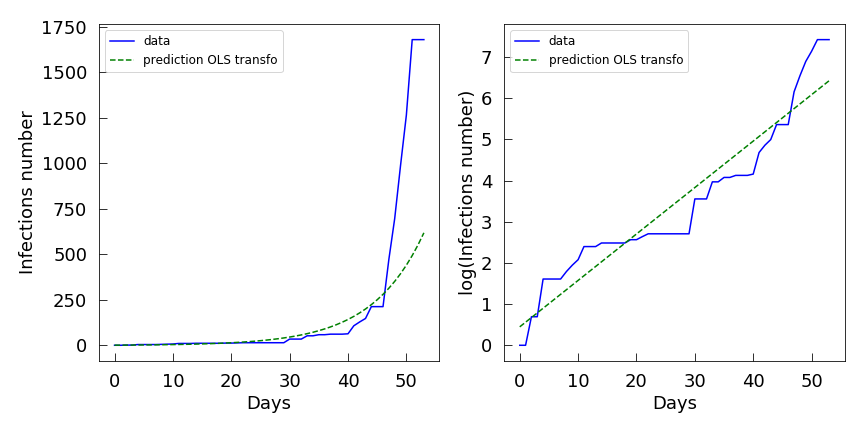

In [15]:
predictedLogInfections = np.array([(0.448 + 0.1128*t) for t in list(df_corona_exp["Days"])])
predictedInfections = np.exp(predictedLogInfections)

fig, ax = plt.subplots(ncols=2,figsize=(12,6))
ax[0].plot(list(df_corona_exp["Days"]),list(df_corona_exp["Infections"]),'b-',label='data')
ax[0].plot(list(df_corona_exp["Days"]),predictedInfections,'g--',label='prediction OLS transfo')
ax[0].set_xlabel('Days')
ax[0].set_ylabel('Infections number')
ax[0].legend(loc='best',fontsize=12)

ax[1].plot(list(df_corona_exp["Days"]),list(df_corona_exp["log_infect"]),'b-',label='data')
ax[1].plot(list(df_corona_exp["Days"]),predictedLogInfections,'g--',label='prediction OLS transfo')

ax[1].set_xlabel('Days')
ax[1].set_ylabel('log(Infections number)')
ax[1].legend(loc='best',fontsize=12)
plt.tight_layout()

**Mini-exercice : given this model how would you deduce the doubling time (mean time it takes for the number of infected to double) ?** 

In [16]:
# answer : the doubling time corresponds to the number of days d, 
# n0*exp(beta*d) = 2*n0*exp(beta*0)
# --> exp(beta*d) = 2
# --> beta*d == log(2)
doubling_time = np.log(2)/0.1128
doubling_time

6.144921813474692

We will see later on how this transformation is already quite a significant first step into GLM,
and how we could have go one step further to actually use a GLM. 

Because, yes, even though this already is quite a pretty good model, there is a more appropriate way of modelling this data. 

Not only is it more appropriate, it is also more accurate and you will see that it matters a lot when trying to make predictions.

#### Practical case 2 : Relation between the presence of  kyphosis and and a few covariates

Let's try to model the chance to develop kyphosis (abnormally excessive convex curvature of the spine) after undergoing a surgical operation that aims at preventing it, according to 3 features :
* age of the patient in months, 
* the number of vertebrea involved in abnormal curvature, 
* where that abnormal curvature starts on the vertebrae. 

In [17]:
df_kyphosis=pd.read_csv('kyphosis.csv')
# replace present/absent with 1/0
df_kyphosis["Kyphosis_0_1"]=[1 if v=="present" else 0 for v in df_kyphosis["Kyphosis"]] 
df_kyphosis.drop("Kyphosis",1,inplace=True)
df_kyphosis.head()

,Age,Number,Start,Kyphosis_0_1
0,71,3,5,0
1,158,3,14,0
2,128,4,5,1
3,2,5,1,0
4,1,4,15,0


<IPython.core.display.Javascript object>


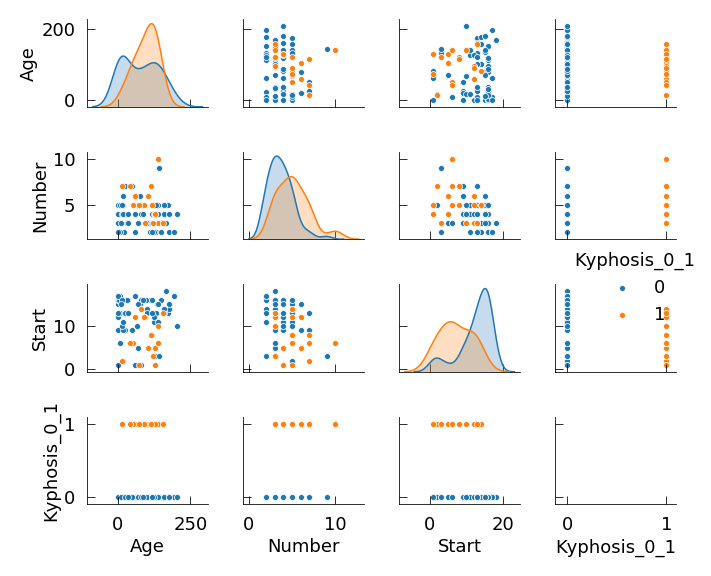

/home/wandrille/Installed_software/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/wandrille/Installed_software/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


In [18]:
sns.pairplot(df_kyphosis,hue="Kyphosis_0_1",height=2,aspect=1)
plt.tight_layout()

Here **the variable we are interested in is either 0 or 1**, and could be seen as the outcome of a bernouilli experiment as it is a binary choice. 

So inherently you already run into a problem here : how do you write a continuous linear function that will give you values between 0 and 1 (close to zero when kyphosis is absent and close to one when kyphosis is present)...

Moreover, again, since you have a bernouilli random variable your mean and your variance are dependant... How are we going to model the absence or presence of kyphosis?


Once again a way to start tackling your problem is to **tranform your variable of interest**, here kyphosis being present or not. Let's write $p$ the probablity that kyphosis is present (Y=1) and thus $1-p$ is the probablity that kyphosis is absent (Y=0). In a bernouilli statistic this $p$ also stand for the average of having Y=1.

The transformation we are going to look at is the log transform of the odds ratio (why? you will understand in a few lines):

$$ln{\frac{p_i}{1-p_i}}=\beta_{0}+\Sigma_{j=1}\beta_{j}x_{j}=\pmb X^T\pmb\beta$$

which translates to

$$p_i=\frac{1}{1+e^{-(\beta_{0}+\Sigma_{j=1}\beta_{j}x_{j})}}$$

So this last equation shows you how we transformed our linear combination of covariables into an outcome between 0 and 1 that relates to the mean of a Bernouilli distribution (if you remember that before we work on relating linearly our covariable to the mean of a gaussian you might see where I am going with that, if not, no worries).


You can see that we change quite a lot the variable of interest: now it's $p$ and it's not an integer just like our `Kyphosis_0_1`. 
Here more than before we drastically shift from modeling the variable to modeling its mean. 
Also, we cannot straight away go from `Kyphosis_0_1` to $p$ (but at least I can show you why it doesn't work). 

We already know that our variable is coming from a bernouilli experiment. So a good approach would be to fit a bernouilli distribution with parameter (mean) $p_i=\frac{1}{1+e^{-(\beta_{0}+\Sigma^{n}_{j=1}\beta_{j}x_{j})}}$, along the curve of our data (juste like what we did for the maximum likelihood with gaussian noise).

As you will see this is exactly what GLM does



**First let's see how using OLS here makes no sense**

In [19]:
import statsmodels
import statsmodels.api as sm
y=df_kyphosis["Kyphosis_0_1"]
X=df_kyphosis[["Age","Number","Start"]]#again making it an array 
X = sm.add_constant(X)#the model doesn't include an intercept automatically so we creat one
model = sm.OLS(y, X)# we create the least square fit object
results = model.fit()#we do the actual fit

res=results.summary()
print(res)

                            OLS Regression Results                            
Dep. Variable:           Kyphosis_0_1   R-squared:                       0.257
Model:                            OLS   Adj. R-squared:                  0.229
Method:                 Least Squares   F-statistic:                     8.900
Date:                Wed, 11 Nov 2020   Prob (F-statistic):           3.91e-05
Time:                        13:48:23   Log-Likelihood:                -30.107
No. Observations:                  81   AIC:                             68.21
Df Residuals:                      77   BIC:                             77.79
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2612      0.193      1.351      0.1

Now let's check what the predicted values are for this model:

<IPython.core.display.Javascript object>


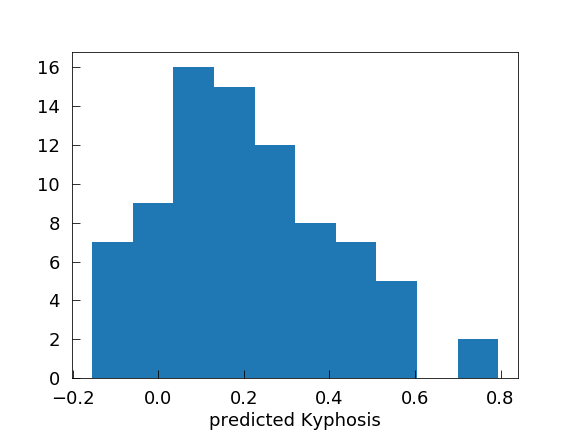

Text(0.5, 0, 'predicted Kyphosis')

In [20]:
fig, ax = plt.subplots(figsize=(8,6))
ax.hist( list(results.fittedvalues) , 10 )
ax.set_xlabel("predicted Kyphosis")

**Those are some irrational values for Kyphosis_1_0**

### Let's define what is the modeling process behind GLM

If you remember, to use our Maximum Likelihood Estimator method, we spent a lot of time before saying that we were looking to solve a very specific kind of problem : one where we wanted to fit the mean of $\pmb Y_i$ knowing some value $\pmb X_i$ , and that there was some gaussian noise $\mathcal{N}(0,\sigma^2)$ around the mean of $\pmb Y_i$.

In mathematical term we were modeling our problem with the following distribution:

$$P(\pmb Y_i|\pmb X_i)=\mathcal{N}(\pmb X_i^{T}\pmb\beta,\sigma^2)$$

On which we were using Maximum Likelihood Estimation 

Thus so far, we have restricted ourselves to purely straightforward linear relations between the mean of $\pmb Y_i$ conditional to $\pmb X_i$ i.e.:

$$\mu(\pmb X_i)=\mathbb{E}(\pmb Y_i|\pmb X_i)=(\pmb X_i^{T}\pmb\beta)$$

# here it is not clear what is meant by conditionnal mean, is it $\bar{y}$ ?

We have also only looked at case where the noise was normaly distributed : hence the $\mathcal{N}$ above. 

Under some conditions (i.e your random component is part of the exponential distribution family) you can relax those conditions.

Remember, as we want to use linear models the only thing we can not change is our fitting using $\pmb X_i^{T}\pmb\beta$. But this linear relationship doesn't have to apply to the conditional mean $\mu(\pmb X_i)$ but instead to a function of that conditional mean:

$$g(\mu(\pmb X_i))=\pmb X_i^{T}\pmb\beta$$

**$g$ is called the link function**, and we will investigate a little bit more what it can be and why it is useful. 


Another possibility is that rather than a normal distribution we could also look for a more general distribution to model the noise induced by the interaction between our $\pmb Y_i$ and $\pmb X_i$:

$$P(\pmb Y_i|\pmb X_i)=\mathcal{D}(g^{-1}(\pmb X_i^{T}\pmb\beta),\sigma^2)$$

Where $\mathcal{D}$ is a distribution that makes sense to model our $\pmb Y$ random variable, and $g^{-1}$ the inverse of the link function.

And on top of that we could still work with our Maximum Likelihood Estimator method.




**So in our first example about exponential growth of Covid cases GLM would have perfom a maximum likelihood on the following distribution:**

$$P(n(t)|t)=\mathcal{P}(n(0)e^{\delta t})$$

Which is a poisson distribution ($\mathcal{P}$) with mean $n(t)=n(0)e^{\beta t}$.

You can recognize the function $g^{-1}:\pmb t^{T}\pmb\beta\rightarrow n(0)e^{\beta t}$, or $g:n(t) \rightarrow log(n(0))+\beta t$


**In our second example about kyphosis GLM would also simply perform maximum likelihood on the following distribution:**


$$P(\pmb K_i|\pmb X_i)=\mathcal{B}(\frac{1}{1+e^{-(\beta_{0}+\Sigma^{n}_{j=1}\beta_{j}x_{j})}})$$

Where $\mathcal{B}$ is the Bernouilli distribution, and $\frac{1}{1+e^{-(\beta_{0}+\Sigma^{n}_{j=1}\beta_{j}x_{j})}}$ corresponds to $p$ in the context of a log-odds-ratio transform.

#### Let's implement our max likelihood and see how stats model can do the same for us

In [21]:
df_corona_exp.keys()

Index(['Infections', 'Days', 'log_infect'], dtype='object')

In [22]:
import scipy as sc

def log_poisson_distri(x,lambda_):
    """ computes the log-PMF for a poisson distribution on a single point"""
    try:
        result=np.log(lambda_)*x-lambda_-np.log(np.math.factorial(x))
    except:
        result=np.log(lambda_)*x-lambda_-(x*np.log(x)-x)
    return result


def poissonLikelihood(para,list_x,list_t):
    
    """ 
        Takes:
            * para (list)   : a list of parameters ( n0 , beta ), 
            * list_y (list) : a list of y (response variable) 
            * list_t (list) : a list of t (covariable).
        Returns
            (float) log-likelihood of the parameters given the data for a poisson model 
    """
    su=0
    for x,t in zip(list_x,list_t):
        lambda_=para[0]*np.exp(para[1]*t)
        su+=log_poisson_distri(x,lambda_)
    return -su


# we optimize this likelihood using a method from scipy.optimize
p1_1=sc.optimize.fmin(poissonLikelihood,
                      [1,1],
                      args=(list(df_corona_exp["Infections"]),
                            list(df_corona_exp["Days"]),),
                      full_output=True)
# arg 1 : the function to optimize
# arg 2 : starting point for each parameters (here, 1 and 1)
# arg 3 : the arguments to give to our likelihood function (except the first one)


Optimization terminated successfully.
         Current function value: 771.284279
         Iterations: 88
         Function evaluations: 164


In [23]:
print('Initial count n(0): ',p1_1[0][0],'    Growth rate beta:',p1_1[0][1])

Initial count n(0):  0.06798165172913803     Growth rate beta: 0.19227434096661228


Now let's see how to do the same thing in `statsmodels` :

In [74]:
import statsmodels
import statsmodels.api as sm
y=df_corona_exp["Infections"]
X=df_corona_exp["Days"]#again making it an array 
X = sm.add_constant(X)#the model doesn't include an intercept automatically so we creat one
model = sm.GLM(y, X, 
               family=sm.families.Poisson( link = sm.families.links.log() ))# family=Poisson link=log
results = model.fit()#we do the actual fit

res=results.summary()
print(res)

                 Generalized Linear Model Regression Results                  
Dep. Variable:             Infections   No. Observations:                   54
Model:                            GLM   Df Residuals:                       52
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -854.83
Date:                Wed, 11 Nov 2020   Deviance:                       1423.8
Time:                        14:53:50   Pearson chi2:                 2.72e+03
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.6891      0.092    -29.212      0.0

<IPython.core.display.Javascript object>


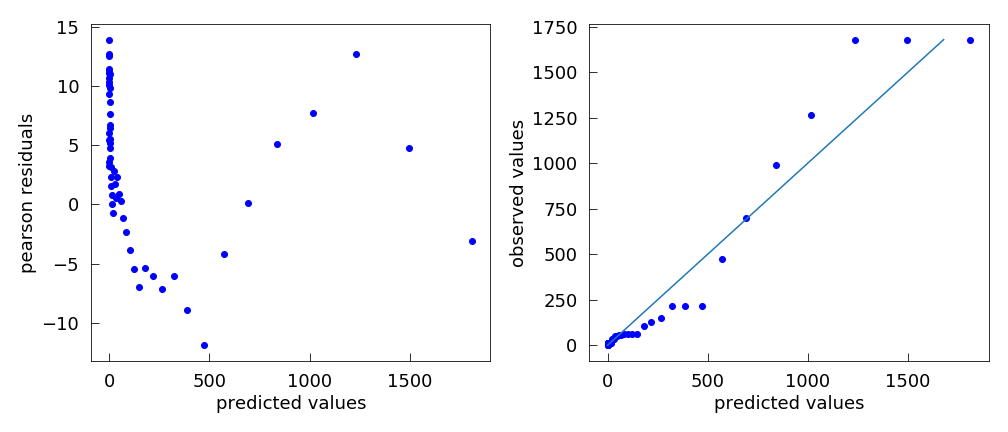

9486.215672040398
52.36900184651036


In [75]:
fig, ax = plt.subplots(ncols=2,figsize=(14,6))
ax[0].plot(results.mu , results.resid_pearson , 'bo')
ax[0].set_xlabel("predicted values")
ax[0].set_ylabel("pearson residuals")

ax[1].plot(results.mu , y , 'bo')
ax[1].plot( [0,max(y)], [0,max(y)] )
ax[1].set_xlabel("predicted values")
ax[1].set_ylabel("observed values")

plt.tight_layout()

print(sum( (results.mu - y)**2 ) / results.df_resid)
print( results.pearson_chi2 / results.df_resid )

<IPython.core.display.Javascript object>


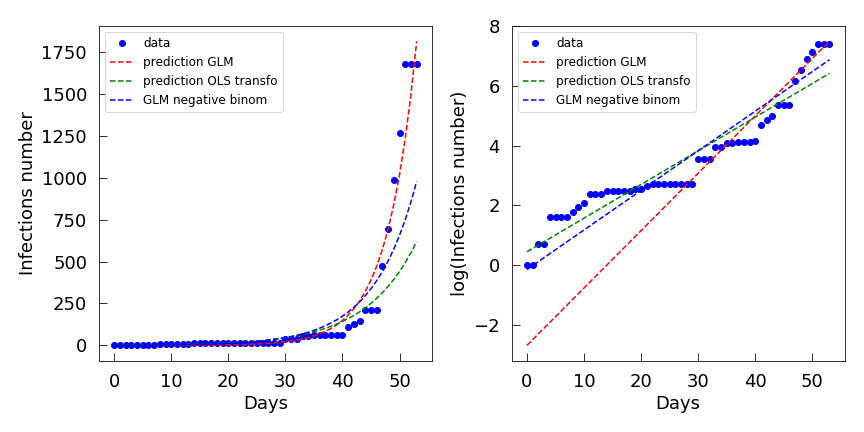

In [77]:
fig, ax = plt.subplots(ncols=2,figsize=(12,6))


As a side note, in this summary, you don't see those F-statistic and t-test reports. Of course, since the noise is not normally distributed anymore.

Instead of the t-statistic you get a **z-statistic instead, which is coming from a Wald test**, with the null hypothesis being that the estimate is 0. This Wald test relies on the computation of the curvature of the log-likelihood function to get the confidence interval on the estimators as well as it's standard error.

You might have also noticed that there is no $\pmb R^2$ anymore. Instead you have the concept of **deviance**. 
It is a way to generalize the concept of $\pmb R^2$ and could be summarized as the log likelihood ratio ($2*(l(X;\hat{\pmb\beta})-l(X;\hat{\beta}_{0}))$) with a null model having only an intercept (in the $\pmb R^2$ we were also comparing the explanatory capability of our model to a null model with only an intercept).

Finally the `"Pearson chi2"` is not important here as it is a test relevant only when your response variable is categorical.



In this model, we can see that both parameters are significantly different from 0.
Remember out model equation is $n(t)=n(0)e^{\beta t}$.
* $n(0)$, the theoretical number of sick people at time 0,  corresponds to `np.exp(const)` $\sim 0.068$
* $\beta$, the growth rate, corresponds to `Days` $= 0.1923$

From this we can deduce the doubling time according to this model : $\frac{log(2)}{\beta} \sim 3.6 days$

This doubling time is much shorter than the one estimated with the OLS on the logarithm of the data, thus predicting a much faster explosion of the number of cases.

Let's plot this new model along side the log-transformed OLS one.

<IPython.core.display.Javascript object>


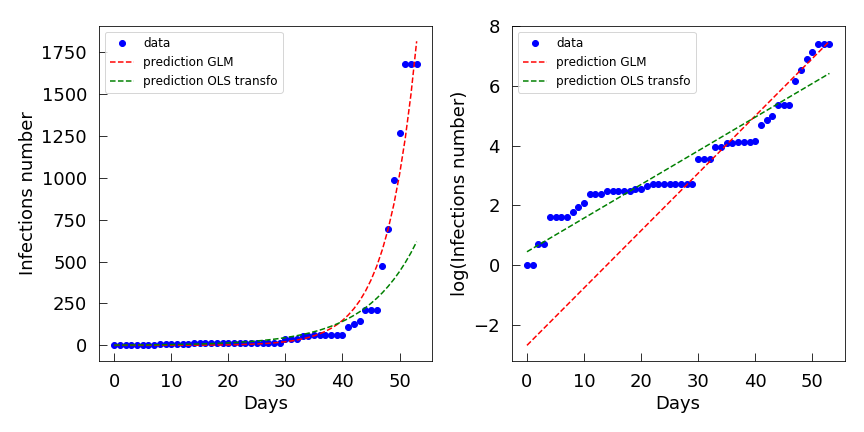

In [38]:
fig, ax = plt.subplots(ncols=2,figsize=(12,6))
ax[0].plot(list(df_corona_exp["Days"]),list(df_corona_exp["Infections"]),'bo',label='data')
ax[0].plot(list(df_corona_exp["Days"]),[np.exp(-2.6891)*np.exp(0.1923*t) for t in list(df_corona_exp["Days"])],'r--',label='prediction GLM')
ax[0].plot(list(df_corona_exp["Days"]),[np.exp(0.448)*np.exp(0.1128*t) for t in list(df_corona_exp["Days"])],'g--',label='prediction OLS transfo')
ax[0].set_xlabel('Days')
ax[0].set_ylabel('Infections number')
ax[0].legend(loc='best',fontsize=12)

ax[1].plot(list(df_corona_exp["Days"]),list(df_corona_exp["log_infect"]),'bo',label='data')
ax[1].plot(list(df_corona_exp["Days"]),[-2.6891+0.1923*t for t in list(df_corona_exp["Days"])],'r--',label='prediction GLM')
ax[1].plot(list(df_corona_exp["Days"]),[0.448+0.1128*t for t in list(df_corona_exp["Days"])],'g--',label='prediction OLS transfo')

ax[1].set_xlabel('Days')
ax[1].set_ylabel('log(Infections number)')
ax[1].legend(loc='best',fontsize=12)
plt.tight_layout()

Our new model, taking into account the Poisson statistic of our response variable is doing way better (mainly in the important exponential phase)! 
We can see that the OLS gravely underestimate the number of infected people later on, while our GLM poisson model performs gives a fairly accurate account.

The apparent lack of fit in the first phase (in particular in the log plot), is due to the disconnect between discrete data and a response variable modelised as a continuous one.




**Let's apply the same to the kyphosis data**

In [196]:
y=df_kyphosis["Kyphosis_0_1"]
X=df_kyphosis[["Age","Number","Start"]] #again making it an array 
X = sm.add_constant(X) #the model doesn't include an intercept automatically so we create one
model = sm.GLM(y, X,family=sm.families.Binomial( link = sm.families.links.logit() ))
# we use a Binomial here even though our cariable is Bernouilli. 
# Because a Binomial with number of try = 1 is a Bernouilli variable, 
# and since we are not providing a number of tries here, the function
# by defafault understands that we want indeed Bernouilli

results = model.fit()#we do the actual fit

res=results.summary()
print(res)

                 Generalized Linear Model Regression Results                  
Dep. Variable:           Kyphosis_0_1   No. Observations:                   81
Model:                            GLM   Df Residuals:                       77
Model Family:                Binomial   Df Model:                            3
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -30.690
Date:                Thu, 05 Nov 2020   Deviance:                       61.380
Time:                        09:28:28   Pearson chi2:                     70.3
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.0369      1.450     -1.405      0.1

In [161]:
print( results.deviance , results.df_resid , 1 - stats.chi2.cdf( results.deviance , results.df_resid ) )


61.37992727645304 77 0.9033442266592783


A few words about Pearson chi square here or is it too much? 
# DEFINITELY

<IPython.core.display.Javascript object>


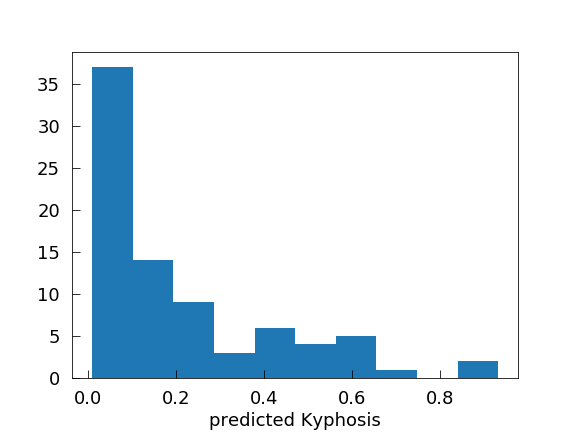

Text(0.5, 0, 'predicted Kyphosis')

In [189]:
fig, ax = plt.subplots(figsize=(8,6))
ax.hist(list(results.fittedvalues),10)
ax.set_xlabel("predicted Kyphosis")

For each patient we have now a probability that this patient will develop Kyphosis. From here we can put a threshold that will tip our decision to **classify** our patient as prone to develop Kyphosis or not.

Notice the use of the word classify. Classification is a notion that we will develop next, from a machine learning perspective. But remember that in that particular case called classification by logistic regression, under the hood the problem is still a problem of regression through a  modelisation using Generalised Linear Model.

We will spend some time introducing key concepts of the classical machine learning framework, first through classification, involving or not under the hood a regression, or even regression in the framework of machine learning.


**Don't know where to put that : demonstration that OLS is just a special case of GLM :**

In [199]:
df_corona_exp.columns

Index(['Infections', 'Days', 'log_infect'], dtype='object')

In [83]:
import statsmodels
import statsmodels.api as sm
y=df_corona_exp["log_infect"]
y2=df_corona_exp["Infections"]
X=df_corona_exp["Days"]#again making it an array 
X = sm.add_constant(X)#the model doesn't include an intercept automatically so we creat one
#model = sm.OLS(y, X)# we create the least square fit object
modelGLM = sm.GLM(y, X , family=sm.families.Gaussian( sm.families.links.identity() ) )
modelOLS = sm.OLS(y, X )

resultsGLM = modelGLM.fit()#we do the actual fit
resultsOLS = modelOLS.fit()#we do the actual fit

print(resultsGLM.summary())
print(resultsOLS.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             log_infect   No. Observations:                   54
Model:                            GLM   Df Residuals:                       52
Model Family:                Gaussian   Df Model:                            1
Link Function:               identity   Scale:                         0.32711
Method:                          IRLS   Log-Likelihood:                -45.433
Date:                Wed, 11 Nov 2020   Deviance:                       17.010
Time:                        15:05:03   Pearson chi2:                     17.0
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4480      0.154      2.918      0.0

<IPython.core.display.Javascript object>


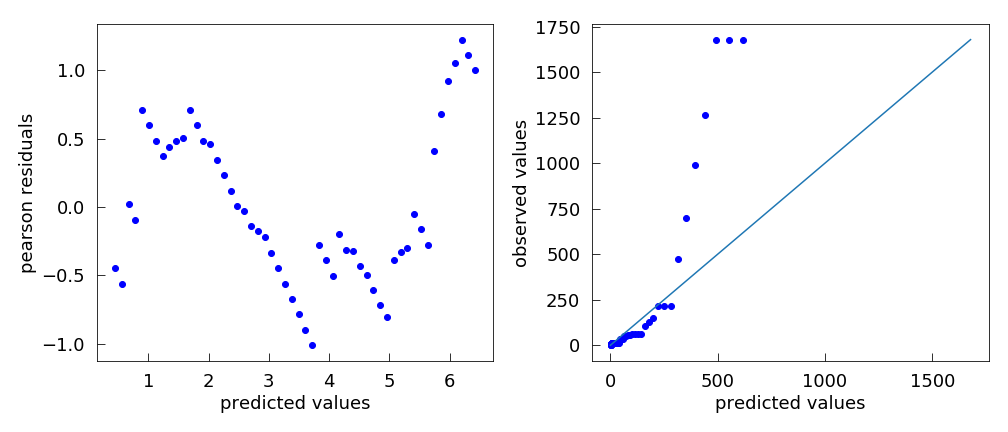

Peasron's residuals in non-log context 4998783.71748919


In [90]:
fig, ax = plt.subplots(ncols=2,figsize=(14,6))
ax[0].plot(resultsGLM.mu , resultsGLM.resid_pearson , 'bo')
ax[0].set_xlabel("predicted values")
ax[0].set_ylabel("pearson residuals")

ax[1].plot( np.exp( resultsGLM.mu ) , np.exp(y) , 'bo')
ax[1].plot( [0,max(np.exp(y))], [0,max(np.exp(y))] )
ax[1].set_xlabel("predicted values")
ax[1].set_ylabel("observed values")

plt.tight_layout()

#let's also compute residuals in the non-log space for a fairer comparison with other models 
expRes = np.exp( resultsGLM.mu ) - np.exp(y)
print( "Peasron's residuals in non-log context" ,sum(expRes**2)) # for the ols model, this actually corresponds to pearson's residuals.


C-T dispersion test: alpha = 0.047, 95% CI = (0.008, 0.086)


<IPython.core.display.Javascript object>


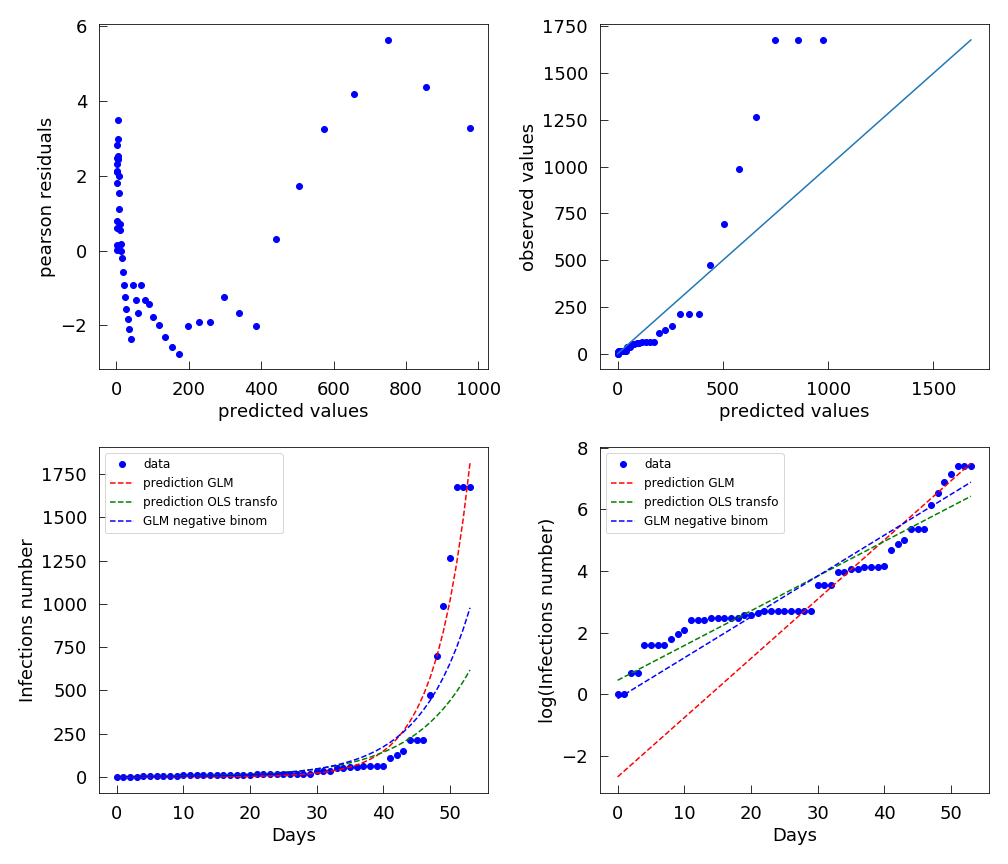

                 Generalized Linear Model Regression Results                  
Dep. Variable:             Infections   No. Observations:                   54
Model:                            GLM   Df Residuals:                       52
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -286.39
Date:                Wed, 11 Nov 2020   Deviance:                       221.17
Time:                        15:03:12   Pearson chi2:                     248.
No. Iterations:                    11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1477      0.129     -1.145      0.2

In [81]:
## trying a negative binomial to account for overdispersion

# from : https://dius.com.au/2017/08/03/using-statsmodels-glms-to-model-beverage-consumption/
# using Cameron-Trivedi dispersion test to estimate alpha
y=df_corona_exp["Infections"]
X=df_corona_exp["Days"]#again making it an array 
X = sm.add_constant(X)#the model doesn't include an intercept automatically so we creat one
model = sm.GLM(y, X, 
               family=sm.families.Poisson( link = sm.families.links.log() ))# family=Poisson link=log
results = model.fit()#we do the actual fit


MU = results.mu
Y = y
RESP = ( (Y-MU)**2 - Y ) / MU

ct_results = sm.OLS( RESP , MU ).fit()
#print(ct_results.summary())
# Construct confidence interval for alpha, the coefficient of bev_mu
alpha_ci95 = ct_results.conf_int(0.05).loc['x1']
print('\nC-T dispersion test: alpha = {:5.3f}, 95% CI = ({:5.3f}, {:5.3f})'.format(ct_results.params[0], alpha_ci95.loc[0], alpha_ci95.loc[1]))
alpha = ct_results.params[0]
##
model = sm.GLM(y, X, 
               family=sm.families.NegativeBinomial( alpha = alpha ))# family=NegativeBinomial link=
results = model.fit()#we do the actual fit


fig, ax = plt.subplots( ncols=2,nrows=2 ,figsize=(14,12))
ax[0][0].plot(results.mu , results.resid_pearson , 'bo')
ax[0][0].set_xlabel("predicted values")
ax[0][0].set_ylabel("pearson residuals")

ax[0][1].plot(results.mu , y , 'bo')
ax[0][1].plot( [0,max(y)], [0,max(y)] )
ax[0][1].set_xlabel("predicted values")
ax[0][1].set_ylabel("observed values")

ax[1][0].plot(list(df_corona_exp["Days"]),list(df_corona_exp["Infections"]),'bo',label='data')
ax[1][0].plot(list(df_corona_exp["Days"]),[np.exp(-2.6891)*np.exp(0.1923*t) for t in list(df_corona_exp["Days"])],'r--',label='prediction GLM')
ax[1][0].plot(list(df_corona_exp["Days"]),[np.exp(0.448)*np.exp(0.1128*t) for t in list(df_corona_exp["Days"])],'g--',label='prediction OLS transfo')
ax[1][0].plot( df_corona_exp["Days"] , results.mu , 'b--',label='GLM negative binom')


ax[1][0].set_xlabel('Days')
ax[1][0].set_ylabel('Infections number')
ax[1][0].legend(loc='best',fontsize=12)

ax[1][1].plot(list(df_corona_exp["Days"]),list(df_corona_exp["log_infect"]),'bo',label='data')
ax[1][1].plot(list(df_corona_exp["Days"]),[-2.6891+0.1923*t for t in list(df_corona_exp["Days"])],'r--',label='prediction GLM')
ax[1][1].plot(list(df_corona_exp["Days"]),[0.448+0.1128*t for t in list(df_corona_exp["Days"])],'g--',label='prediction OLS transfo')
ax[1][1].plot( df_corona_exp["Days"] , np.log(results.mu) , 'b--',label='GLM negative binom')

ax[1][1].set_xlabel('Days')
ax[1][1].set_ylabel('log(Infections number)')
ax[1][1].legend(loc='best',fontsize=12)
plt.tight_layout()

plt.tight_layout()

res=results.summary()
print(res)

# Exo GLM : dose response?

In the following dataset we would like to model the death rate of beetles due to some pesticide concentration.

In [147]:
df_beetles=pd.read_csv('beetle.csv')
#df_beetles["odd"]=[df_beetles["ndied"][l]/df_beetles["nalive"][l] for l in range(len(df_beetles["ndied"]))]
df_beetles.head(100)

,Unnamed: 0,dose,nexp,ndied,prop,nalive
0,1,49.1,59,6,0.102,53
1,2,53.0,60,13,0.217,47
2,3,56.9,62,18,0.290,44
3,4,60.8,56,28,0.500,28
4,5,64.8,63,52,0.825,11
5,6,68.7,59,53,0.898,6
6,7,72.6,62,61,0.984,1
7,8,76.5,60,60,1.000,0


<IPython.core.display.Javascript object>


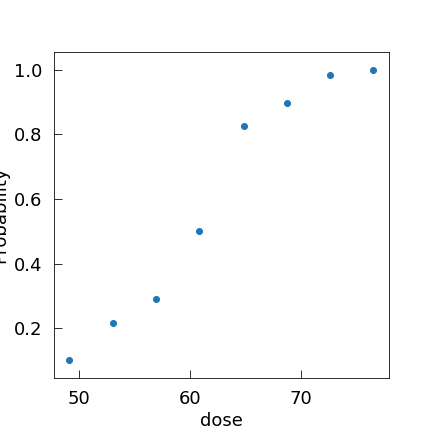

Text(0, 0.5, 'Probability')

In [148]:
fig, ax = plt.subplots(ncols=1,figsize=(6,6))
ax.scatter(list(df_beetles["dose"]),list(df_beetles["prop"]))
ax.set_xlabel('dose')
ax.set_ylabel('Probability')

In [149]:

y=df_beetles[["ndied","nalive"]]
#since we want our random variable to be represented by a binomial we need two parameters
#to define a binomial.

X = df_beetles["dose"]
X = sm.add_constant(X)
model = sm.GLM(y, X,family=sm.families.Binomial())
results = model.fit()

res=results.summary()
print(res)

                  Generalized Linear Model Regression Results                  
Dep. Variable:     ['ndied', 'nalive']   No. Observations:                    8
Model:                             GLM   Df Residuals:                        6
Model Family:                 Binomial   Df Model:                            1
Link Function:                   logit   Scale:                          1.0000
Method:                           IRLS   Log-Likelihood:                -16.791
Date:                 Thu, 29 Oct 2020   Deviance:                       7.3849
Time:                         17:33:17   Pearson chi2:                     6.52
No. Iterations:                      6                                         
Covariance Type:             nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -14.8230      1.290    -11.49

<IPython.core.display.Javascript object>


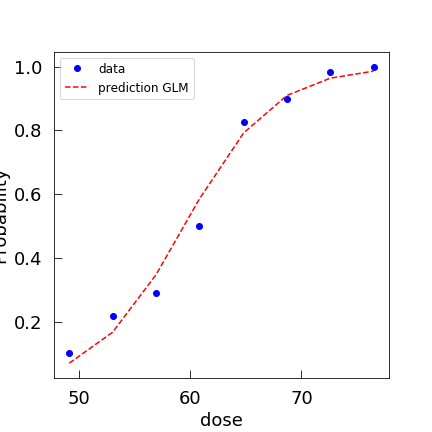

In [150]:

fig, ax = plt.subplots(ncols=1,figsize=(6,6))
ax.plot(list(df_beetles["dose"]),list(df_beetles["prop"]),'bo',label='data')
ax.plot(list(df_beetles["dose"]),[ 1./(1+np.exp(-(-14.8230+0.2494*t)))for t in list(df_beetles["dose"])],'r--',label='prediction GLM')

ax.set_xlabel('dose')
ax.set_ylabel('Probability')
ax.legend(loc='best',fontsize=12)
